# Implementation
Author: Jørgen S. Dokken

In this section, we will solve the deflection of the membrane problem.
After finishing this section, you should be able to:
- Create a simple mesh using the GMSH Python API and load it into DOLFINx
- Create constant boundary conditions using a geometrical identifier
- Use `ufl.SpatialCoordinate` to create a spatially varying function
- Interpolate a `ufl.Expression` into an appropriate function space
- Evaluate a `dolfinx.Function` at any point $x$
- Use Paraview to visualize the solution of a PDE

## Creating the mesh

To create the computational geometry, we use the python-API of [GMSH](http://gmsh.info/). We start by importing the gmsh-module and initializing it.

In [1]:
import gmsh
gmsh.initialize()

The next step is to create the membrane and start the computations by the GMSH CAD kernel, to generate the relevant underlying data structures. The first arguments of `addDisk` are the x, y and z coordinate of the center of the circle, while the two last arguments are the x-radius and y-radius.

In [2]:
membrane = gmsh.model.occ.addDisk(0, 0, 0, 1, 1)
gmsh.model.occ.synchronize()

After that, we make the membrane a physical surface, such that it is recognized by `gmsh` when generating the mesh. As a surface is a two-dimensional entity, we add `2` as the first argument, the entity tag of the membrane as the second argument, and the physical tag as the last argument. In a later demo, we will get into when this tag matters.

In [3]:
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [membrane], 1)

1

Finally, we generate the two-dimensional mesh. We set a uniform mesh size by modifying the GMSH options.

In [4]:
gmsh.option.setNumber("Mesh.CharacteristicLengthMin",0.05)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.05)
gmsh.model.mesh.generate(gdim)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000141326s, CPU 0.000332s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0678559s, CPU 0.068945s)
Info    : 1550 nodes 3099 elements


# Interfacing with GMSH in DOLFINx
We will import the GMSH-mesh directly from GMSH into DOLFINx via the `dolfinx.io.gmshio` interface.
As in this example, we have not specified which process we have created the `gmsh` model on, a model has been created on each mpi process. However, we would like to be able to use a mesh distributed over all processes. Therefore, we take the model generated on rank 0 of `MPI.COMM_WORLD`, and distribute it over all available ranks. We will also get two mesh tags, one for cells marked with physical groups in the mesh and one for facets marked with physical groups. As we did not add any physical groups of dimension `gdim-1`, there will be no entities in the `facet_markers`.

In [5]:
from dolfinx.io import gmshio
from mpi4py import MPI

gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD
domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

We define the function space as in the previous tutorial

In [6]:
from dolfinx import fem
V = fem.FunctionSpace(domain, ("CG", 1))

## Defining a spatially varying load
The right hand side pressure function is represented using `ufl.SpatialCoordinate` and two constants, one for $\beta$ and one for $R_0$.

In [7]:
import ufl
from petsc4py.PETSc import ScalarType
x = ufl.SpatialCoordinate(domain)
beta = fem.Constant(domain, ScalarType(12))
R0 = fem.Constant(domain, ScalarType(0.3))
p = 4 * ufl.exp(-beta**2 * (x[0]**2 + (x[1] - R0)**2))

## Create a Dirichlet boundary condition using geometrical conditions
The next step is to create the homogeneous boundary condition. As opposed to the [first tutorial](./fundamentals_code.ipynb) we will use `dolfinx.fem.locate_dofs_geometrical` to locate the degrees of freedom on the boundary. As we know that our domain is a circle with radius 1, we know that any degree of freedom should be located at a coordinate $(x,y)$ such that $\sqrt{x^2+y^2}=1$.

In [8]:
import numpy as np
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), 1)
boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

As our Dirichlet condition is homogeneous (`u=0` on the whole boundary), we can initialize the `dolfinx.fem.dirichletbc` with a constant value, the degrees of freedom and the function space to apply the boundary condition on.

In [9]:
bc = fem.dirichletbc(ScalarType(0), boundary_dofs, V)

## Defining the variational problem
The variational problem is the same as in our first Poisson problem, where `f` is replaced by `p`.

In [10]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = p * v * ufl.dx
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

## Interpolation of a `ufl`-expression
As we previously defined the load `p` as a spatially varying function, we would like to interpolate this function into an appropriate function space for visualization. To do this we use the `dolfinx.Expression`. The expression takes in any `ufl`-expression, and a set of points on the reference element. We will use the interpolation points of the space we want to interpolate in to.
We choose a high order function space to represent the function `p`, as it is rapidly varying in space.

In [11]:
Q = fem.FunctionSpace(domain, ("CG", 5))
expr = fem.Expression(p, Q.element.interpolation_points())
pressure = fem.Function(Q)
pressure.interpolate(expr)

## Plotting the solution over a line
We first plot the deflection $u_h$ over the domain $\Omega$.


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



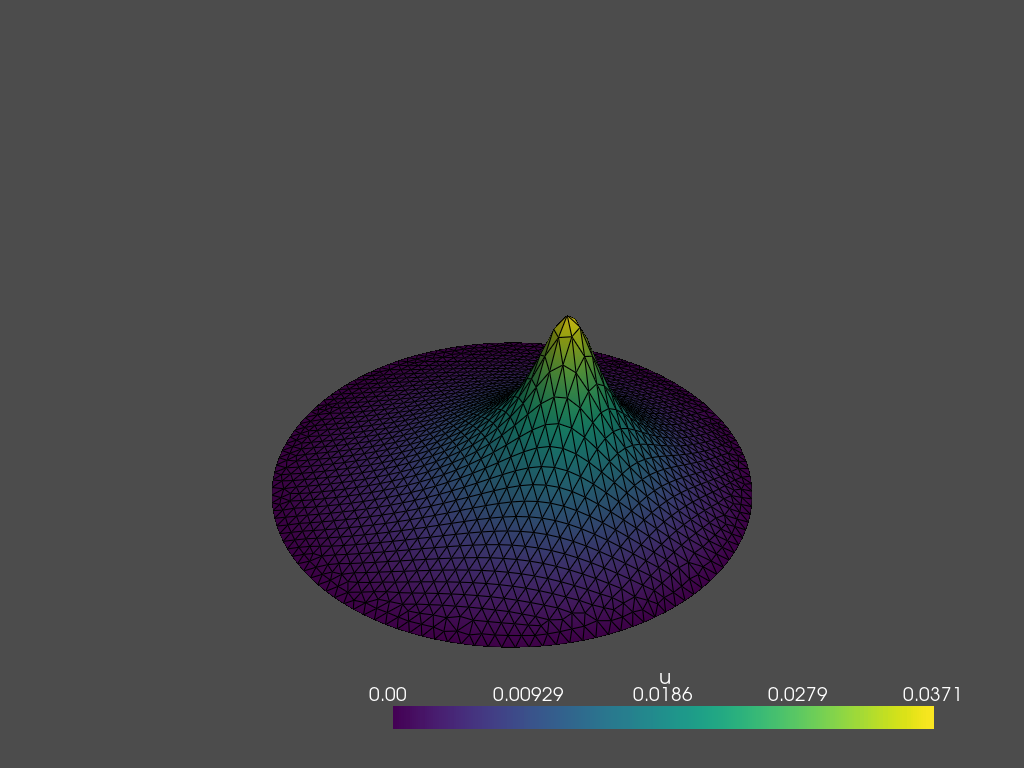

In [12]:
from dolfinx.plot import create_vtk_mesh
import pyvista
pyvista.start_xvfb()

# Extract topology from mesh and create pyvista mesh
topology, cell_types, x = create_vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)

# Set deflection values and add it to plotter
grid.point_data["u"] = uh.x.array
warped = grid.warp_by_scalar("u", factor=25)

plotter = pyvista.Plotter()
plotter.add_mesh(warped, show_edges=True, show_scalar_bar=True, scalars="u")
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot("deflection.png")

We next plot the load on the domain

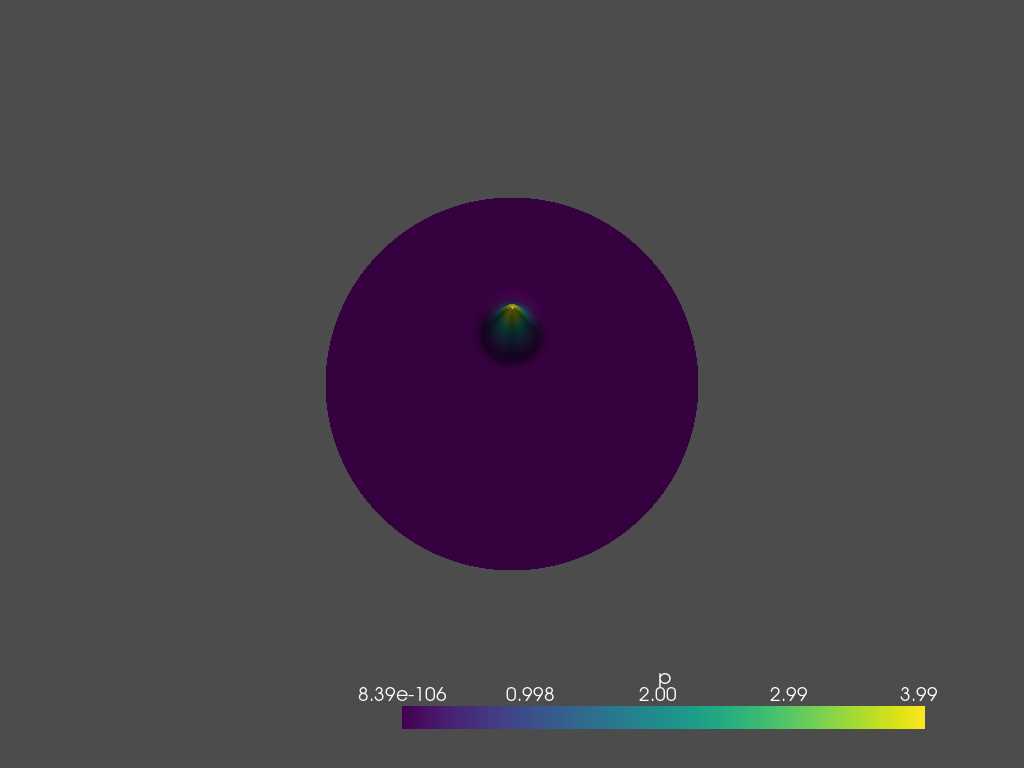

In [13]:
load_plotter = pyvista.Plotter()
p_grid = pyvista.UnstructuredGrid(*create_vtk_mesh(Q))
p_grid.point_data["p"] = pressure.x.array.real
warped_p = p_grid.warp_by_scalar("p", factor=0.5)
warped_p.set_active_scalars("p")
load_plotter.add_mesh(warped_p, show_scalar_bar=True)
load_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    load_plotter.show()
else:
    load_plotter.screenshot("load.png")

## Making curve plots throughout the domain
Another way to compare the deflection and the load is to make a plot along the line $x=0$. 
This is just a matter of defining a set of points along the $y$-axis and evaluating the finite element functions $u$ and $p$ at these points. We only define the points on one process, as we will distribute them by determining their ownership.

In [14]:
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
if domain.comm.rank == 0:
    points = np.zeros((3, 101))
    points[1] = y
else: 
    # Only add points on one process
    points = np.zeros((3, 0))
from dolfinx.cpp.geometry import determine_point_ownership
_, _, points_on_process, cells = determine_point_ownership(domain, points.T)
points_on_process = np.array(points_on_process).reshape(len(points_on_process)//3, 3)

We now got a list of points on the processor, on in which cell each point belongs. We can then call `uh.eval` and `pressure.eval` to obtain the set of values for all the points.

In [15]:
u_values = uh.eval(points_on_process, cells)
p_values = pressure.eval(points_on_process, cells)

As we now have an array of coordinates and two arrays of function values, we can use `matplotlib` to plot them

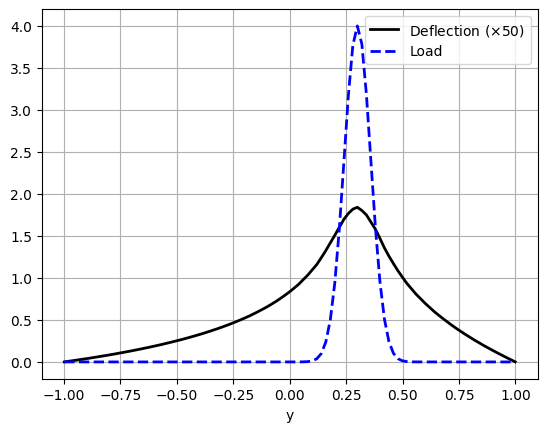

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(points_on_process[:,1], 50*u_values, "k", linewidth=2, label="Deflection ($\\times 50$)")
plt.plot(points_on_process[:, 1], p_values, "b--", linewidth = 2, label="Load")
plt.grid(True)
plt.xlabel("y")
plt.legend()
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"membrane_rank{MPI.COMM_WORLD.rank:d}.png")

## Saving functions to file
As mentioned in the previous section, we can also use Paraview to visualize the solution.

In [17]:
import dolfinx.io
pressure.name = "Load"
uh.name = "Deflection"
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "results_membrane.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(pressure)
    xdmf.write_function(uh)